In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
import holidays
from datetime import timedelta
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from category_encoders.target_encoder import TargetEncoder
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingRegressor

from lightgbm import LGBMRegressor
import optuna

In [2]:
warnings.simplefilter('ignore', category=FutureWarning)

## Prepairing

In [3]:
# Таргет-энкодер и модель для предсказаний на 1 день
target_encoder_1d = joblib.load('../files/target_encoder_1d')
lgbm_pipeline_1d = joblib.load('../files/lgbm_pipeline_1d')

In [4]:
# Функция извлечения признаков, для предсказаний на 1 день
def features_extractor_1d(dataset, target_encoder):
    features = pd.DataFrame()
    res_dataset = dataset.resample('1D')

    # Вчерашняя температура
    features['temp_pred'] = res_dataset.agg({'temp_pred': 'mean'})
    features['yst_temp_min'] = res_dataset.agg({'temp': 'min'}).shift(1)
    features['yst_temp_med'] = res_dataset.agg({'temp': 'median'}).shift(1)
    for i in range(3):
        features[f'yst_temp_mean{i+1}'] = res_dataset.agg({'temp': 'mean'}).shift(i+1)
    features['yst_temp_max'] = res_dataset.agg({'temp': 'max'}).shift(1)
    features['yst_temp_last'] = dataset.query('time==23')['temp'].shift(1)
    # Вчерашний таргет
    features['yst_target_min'] = res_dataset.agg({'target': 'min'}).shift(1)
    features['yst_target_med'] = res_dataset.agg({'target': 'median'}).shift(1)
    features['yst_target_mean'] = res_dataset.agg({'target': 'mean'}).shift(1)
    features['yst_target_max'] = res_dataset.agg({'target': 'max'}).shift(1)
    features['yst_target_last'] = dataset.query('time==23')['target'].shift(1)

    # Погода энкодед
    features[['weather_pred', 'yst_weather_fact_1']] = (
        target_encoder.transform(dataset[['weather_pred', 'weather_fact']]).resample('D').mean()
    )
    features['yst_weather_fact_1'] = features['yst_weather_fact_1'].shift(1)
    for i in range(1, 2):
        features[f'yst_weather_fact_{i+1}'] = features['yst_weather_fact_1'].shift(i+1)


    # Лаг
    for i in range(31):
        features[f'target_lag_{i+1}'] = res_dataset.agg({'target': 'sum'}).shift(i+1)


    # Дни
    features['week_day'] = features.index.dayofweek
    features['year'] = features.index.year
    features['month'] = features.index.month
    features['day'] = features.index.day
    #features['quarter'] = (features.index.month - 1) // 3 + 1

    # Выходные праздники
    #features['is_weekend'] = [1 if day == 6 or day == 0 else 0 for day in features.week_day]
    holidays_list = []
    for i in holidays.RUS(years=[2019, 2020, 2021, 2022, 2023]).items():
        holidays_list.append(str(i[0]))
    holidays_list = holidays_list + ['2019-12-31', '2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31']
    features['is_holiday'] = [1 if str(val).split()[0] in holidays_list else 0 for val in features.index]

    features = features.dropna()
    return features

In [5]:
# Функция извлечения признаков, для предсказаний на 1 час
def features_extractor(dataset, target_encoder, predict_1d):
    features = pd.DataFrame()
    
    features['time'] = dataset['time']
    
    # Температура
    features['temp_pred'] = dataset['temp_pred']
    features['temp_pred'] = features['temp_pred'].ffill()
    features['yst_temp'] = dataset['temp'].shift(24)
    features['yst_temp_mean'] = features.resample('1D').agg({'yst_temp': 'mean'})
    features['yst_temp_med'] = features.resample('1D').agg({'yst_temp': 'median'})
    
    # Погода
    features['weather_pred'] = dataset['weather_pred']
    features['weather_pred'] = features['weather_pred'].ffill()
    features['weather_fact'] = dataset['weather_fact'].shift(24)
    features[['weather_pred', 'weather_fact']] = (
        target_encoder.transform(features[['weather_pred', 'weather_fact']])
    )
    features = features.rename(columns={'weather_fact': 'yst_weather_fact'})
    features['yst_weather_fact_mean'] = features.resample('1D').agg({'yst_weather_fact': 'mean'})
    features['yst_weather_fact_med'] = features.resample('1D').agg({'yst_weather_fact': 'median'})
    
    # Лаг таргета на 7 дней
    for i in range(24, 192, 24):
        features[f'yst_target_{i}'] = dataset['target'].shift(i)
    
    features['yst_target_sum'] = features.resample('1D').agg({'yst_target_24': 'sum'})
    
    # Предикт на 1 день
    features = features.join(predict_1d)

    # Дни
    features['week_day'] = features.index.dayofweek
    features['year'] = features.index.year
    features['month'] = features.index.month
    features['day'] = features.index.day
    
    # Праздники
    holidays_list = []
    for i in holidays.RUS(years=[2019, 2020, 2021, 2022, 2023]).items():
        holidays_list.append(str(i[0]))
    holidays_list = holidays_list + ['2019-12-31', '2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31']
    features['is_holiday'] = [1 if str(val).split()[0] in holidays_list else 0 for val in features.index]
    
    features = features.dropna()
    return features

In [6]:
# Функция для извлечения таргета
def target_creator(dataset, features_idx):
    target = dataset['target']
    target = target.loc[features_idx.unique()]
    return target

In [7]:
target_encoder = TargetEncoder()
scaler = MinMaxScaler()
CV = TimeSeriesSplit(n_splits=5)

## TRAIN

In [8]:
df_train = pd.read_csv('../data/train_dataset.csv', index_col='date', parse_dates=True)
df_train

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...
2023-03-31,19,552.960,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31,20,563.985,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31,21,560.191,6.3,5.0,"пасм, 61%","пасм, дымка"


In [9]:
# Извлекаем признаки для предсказания суммарного потребления электричества на 1 день
features_train_1d = features_extractor_1d(df_train, target_encoder_1d)

In [10]:
# Получаем предсказания суммарного потребления на 1 день 
predict_train_1d = pd.DataFrame(
    lgbm_pipeline_1d.predict(features_train_1d),
    index=features_train_1d.index,
    columns=['target_sum_pred']
)

In [11]:
target_encoder.fit(df_train[['weather_pred', 'weather_fact']], df_train['target'])

TargetEncoder(cols=['weather_pred', 'weather_fact'])

In [12]:
features_train = features_extractor(df_train, target_encoder, predict_train_1d)
features_train

,time,temp_pred,yst_temp,yst_temp_mean,yst_temp_med,weather_pred,yst_weather_fact,yst_weather_fact_mean,yst_weather_fact_med,yst_target_24,...,yst_target_120,yst_target_144,yst_target_168,yst_target_sum,target_sum_pred,week_day,year,month,day,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2019-02-01,0,-2.0,-5.4,-2.2125,-1.40,569.001286,497.958169,508.221174,509.859225,551.764,...,574.720,578.847,576.305,14543.391,14357.495085,4,2019,2,1,0
2019-02-01,1,-2.0,-5.4,-2.2125,-1.40,569.001286,497.958169,508.221174,509.859225,509.703,...,538.396,538.638,537.491,14543.391,14357.495085,4,2019,2,1,0
2019-02-01,2,-2.0,-5.4,-2.2125,-1.40,569.001286,497.958169,508.221174,509.859225,486.041,...,513.026,512.829,515.493,14543.391,14357.495085,4,2019,2,1,0
2019-02-01,3,-3.0,-4.7,-2.2125,-1.40,569.001286,497.958169,508.221174,509.859225,476.100,...,501.166,500.753,504.864,14543.391,14357.495085,4,2019,2,1,0
2019-02-01,4,-3.0,-4.7,-2.2125,-1.40,569.001286,497.958169,508.221174,509.859225,471.236,...,491.833,494.790,498.515,14543.391,14357.495085,4,2019,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,19,6.0,7.8,7.4375,7.45,485.578462,492.763055,504.097550,509.859225,561.542,...,544.108,534.198,559.747,12478.985,12296.416474,4,2023,3,31,0
2023-03-31,20,6.0,7.8,7.4375,7.45,485.578462,492.763055,504.097550,509.859225,582.464,...,560.807,556.276,570.206,12478.985,12296.416474,4,2023,3,31,0
2023-03-31,21,5.0,7.1,7.4375,7.45,485.578462,492.763055,504.097550,509.859225,571.899,...,564.381,551.944,555.419,12478.985,12296.416474,4,2023,3,31,0


In [13]:
target_train = target_creator(df_train, features_train.index)
target_train

date
2019-02-01    557.528
2019-02-01    519.482
2019-02-01    494.380
2019-02-01    484.917
2019-02-01    478.837
               ...   
2023-03-31    552.960
2023-03-31    563.985
2023-03-31    560.191
2023-03-31    538.796
2023-03-31    518.685
Name: target, Length: 36480, dtype: float64

In [14]:
features_train.shape, target_train.shape

((36480, 23), (36480,))

### Linear Regression

In [15]:
linear_pipeline = make_pipeline(scaler, LinearRegression())
linear_pipeline.fit(features_train, target_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [16]:
lin_cv_mae = -np.mean(cross_val_score(
    linear_pipeline,
    features_train,
    target_train,
    scoring='neg_mean_absolute_error',
    cv=CV
))

In [17]:
lin_mae = mean_absolute_error(target_train, linear_pipeline.predict(features_train))

### LightGBM Regressor

In [18]:
def objective(trial):
    # Объявляем гиперпараметры для оптимизации
    params = {
        'objective': trial.suggest_categorical('objective', ['regression', 'regression_l1']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0, 1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
        #'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 1),
        #'min_sum_hessian_in_leaf': trial.suggest_int('min_sum_hessian_in_leaf', 1, 7, 2),
        'random_state': 42,
        'verbosity': -1
    }

    # Объявляем модель
    model = LGBMRegressor(**params)
    pipeline = make_pipeline(scaler, model)

    # Вычисляем качество
    result = cross_val_score(
        pipeline,
        features_train,
        target_train,
        scoring='neg_mean_absolute_error',
        cv=CV).mean() * -1

    return result

In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=300, n_jobs=-1)

In [20]:
lgbm_model = LGBMRegressor(**study.best_params, random_state=42, verbosity=-1, n_jobs=-1)
lgbm_pipeline = make_pipeline(scaler, lgbm_model)
lgbm_pipeline.fit(features_train, target_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('lgbmregressor',
                 LGBMRegressor(bagging_fraction=0.12279426156101786,
                               feature_fraction=0.8261399567164694,
                               lambda_l1=0.5337856302146861,
                               lambda_l2=0.5840753284668943,
                               learning_rate=0.08664347350145621, max_depth=7,
                               n_estimators=592, n_jobs=-1, num_leaves=43,
                               objective='regression', random_state=42,
                               verbosity=-1))])

In [21]:
lgbm_cv_mae = -np.mean(cross_val_score(
    lgbm_pipeline,
    features_train,
    target_train,
    scoring='neg_mean_absolute_error',
    cv=CV
))

In [22]:
lgbm_mae = mean_absolute_error(target_train, lgbm_pipeline.predict(features_train))

### Results

In [24]:
print(f'Linear MAE: {lin_mae} \n'
      f'Linear CV MAE: {lin_cv_mae} \n'
      f'LGBM MAE: {lgbm_mae} \n'
      f'LGBM CV MAE: {lgbm_cv_mae}')

Linear MAE: 10.217016339583152 
Linear CV MAE: 10.788932501552225 
LGBM MAE: 3.279817764679669 
LGBM CV MAE: 9.440636302735648


## TEST

In [25]:
df_test = pd.read_csv('../data/test_dataset.csv', index_col='date', parse_dates=True)
df_test

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...
2023-07-31,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл


In [26]:
get_idx = [df_test.index[0] - timedelta(days=i) for i in range(1, 32)]

In [27]:
df_test = pd.concat([df_test, df_train.loc[get_idx]], axis=0)
df_test = df_test.sort_values(by=['date', 'time'])
df_test

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-03-01,0,512.865,2.5,2.0,пасм,пасмурно
2023-03-01,1,478.071,2.5,2.0,пасм,пасмурно
2023-03-01,2,456.643,2.5,2.0,пасм,пасмурно
2023-03-01,3,448.305,1.5,1.0,пасм,"пасм, ветерок"
2023-03-01,4,442.351,1.5,1.0,пасм,"пасм, ветерок"
...,...,...,...,...,...,...
2023-07-31,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл


In [28]:
# Извлекаем признаки для предсказания суммарного потребления электричества на 1 день
features_test_1d = features_extractor_1d(df_test, target_encoder_1d)

In [29]:
# Получаем предсказания суммарного потребления на 1 день 
predict_test_1d = pd.DataFrame(
    lgbm_pipeline_1d.predict(features_test_1d),
    index=features_test_1d.index,
    columns=['target_sum_pred']
)

In [30]:
features_test = features_extractor(df_test, target_encoder, predict_test_1d)
features_test

,time,temp_pred,yst_temp,yst_temp_mean,yst_temp_med,weather_pred,yst_weather_fact,yst_weather_fact_mean,yst_weather_fact_med,yst_target_24,...,yst_target_120,yst_target_144,yst_target_168,yst_target_sum,target_sum_pred,week_day,year,month,day,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2023-04-01,0,5.0,7.2,8.8125,7.9,459.902061,492.763055,514.485231,501.311140,481.201,...,469.910,467.235,474.667,12414.945,12015.122396,5,2023,4,1,0
2023-04-01,1,5.0,7.2,8.8125,7.9,459.902061,492.763055,514.485231,501.311140,446.881,...,436.449,434.829,443.669,12414.945,12015.122396,5,2023,4,1,0
2023-04-01,2,5.0,7.2,8.8125,7.9,459.902061,492.763055,514.485231,501.311140,425.556,...,415.774,412.991,420.886,12414.945,12015.122396,5,2023,4,1,0
2023-04-01,3,4.0,7.9,8.8125,7.9,503.832900,492.763055,514.485231,501.311140,416.225,...,404.896,400.996,409.593,12414.945,12015.122396,5,2023,4,1,0
2023-04-01,4,4.0,7.9,8.8125,7.9,503.832900,492.763055,514.485231,501.311140,411.703,...,401.041,395.980,405.119,12414.945,12015.122396,5,2023,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,19,18.0,19.7,18.8250,18.0,528.770689,470.997571,481.880313,481.880313,429.767,...,446.658,450.699,452.459,9296.344,9692.016364,0,2023,7,31,0
2023-07-31,20,18.0,19.7,18.8250,18.0,528.770689,470.997571,481.880313,481.880313,424.231,...,438.176,440.681,447.430,9296.344,9692.016364,0,2023,7,31,0
2023-07-31,21,17.0,16.6,18.8250,18.0,528.770689,470.997571,481.880313,481.880313,433.278,...,438.106,438.982,451.141,9296.344,9692.016364,0,2023,7,31,0


In [31]:
target_test = target_creator(df_test, features_test.index)
target_test

date
2023-04-01    479.282
2023-04-01    445.182
2023-04-01    424.225
2023-04-01    413.866
2023-04-01    408.146
               ...   
2023-07-31    453.173
2023-07-31    446.287
2023-07-31    444.373
2023-07-31    449.078
2023-07-31    416.078
Name: target, Length: 2928, dtype: float64

In [32]:
features_test.shape, target_test.shape

((2928, 23), (2928,))

In [33]:
lin_mae = mean_absolute_error(target_test, linear_pipeline.predict(features_test))
lgbm_mae = mean_absolute_error(target_test, lgbm_pipeline.predict(features_test))

In [34]:
print(f'Linear MAE: {lin_mae} \n'
      f'LGBM MAE: {lgbm_mae} \n')

Linear MAE: 8.575979749465088 
LGBM MAE: 6.674075055204502 


## FULL

In [35]:
CV = TimeSeriesSplit(n_splits=27)

In [36]:
df_full = pd.concat([
    pd.read_csv('../data/train_dataset.csv', index_col='date', parse_dates=True),
    pd.read_csv('../data/test_dataset.csv', index_col='date', parse_dates=True)
], axis=0)

In [37]:
df_full

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...
2023-07-31,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл


In [38]:
# Извлекаем признаки для предсказания суммарного потребления электричества на 1 день
features_full_1d = features_extractor_1d(df_full, target_encoder_1d)

In [39]:
# Получаем предсказания суммарного потребления на 1 день 
predict_full_1d = pd.DataFrame(
    lgbm_pipeline_1d.predict(features_full_1d),
    index=features_full_1d.index,
    columns=['target_sum_pred']
)

In [40]:
target_encoder.fit(df_full[['weather_pred', 'weather_fact']], df_full['target'])

TargetEncoder(cols=['weather_pred', 'weather_fact'])

In [41]:
features_full = features_extractor(df_full, target_encoder, predict_full_1d)
features_full

,time,temp_pred,yst_temp,yst_temp_mean,yst_temp_med,weather_pred,yst_weather_fact,yst_weather_fact_mean,yst_weather_fact_med,yst_target_24,...,yst_target_120,yst_target_144,yst_target_168,yst_target_sum,target_sum_pred,week_day,year,month,day,is_holiday
date,,,,,,,,,,,,,,,,,,,,,
2019-02-01,0,-2.0,-5.4,-2.2125,-1.4,567.446299,494.72471,505.506553,507.804703,551.764,...,574.720,578.847,576.305,14543.391,14357.495085,4,2019,2,1,0
2019-02-01,1,-2.0,-5.4,-2.2125,-1.4,567.446299,494.72471,505.506553,507.804703,509.703,...,538.396,538.638,537.491,14543.391,14357.495085,4,2019,2,1,0
2019-02-01,2,-2.0,-5.4,-2.2125,-1.4,567.446299,494.72471,505.506553,507.804703,486.041,...,513.026,512.829,515.493,14543.391,14357.495085,4,2019,2,1,0
2019-02-01,3,-3.0,-4.7,-2.2125,-1.4,567.446299,494.72471,505.506553,507.804703,476.100,...,501.166,500.753,504.864,14543.391,14357.495085,4,2019,2,1,0
2019-02-01,4,-3.0,-4.7,-2.2125,-1.4,567.446299,494.72471,505.506553,507.804703,471.236,...,491.833,494.790,498.515,14543.391,14357.495085,4,2019,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,19,18.0,19.7,18.8250,18.0,510.031230,467.27507,477.169233,477.169233,429.767,...,446.658,450.699,452.459,9296.344,9692.016364,0,2023,7,31,0
2023-07-31,20,18.0,19.7,18.8250,18.0,510.031230,467.27507,477.169233,477.169233,424.231,...,438.176,440.681,447.430,9296.344,9692.016364,0,2023,7,31,0
2023-07-31,21,17.0,16.6,18.8250,18.0,510.031230,467.27507,477.169233,477.169233,433.278,...,438.106,438.982,451.141,9296.344,9692.016364,0,2023,7,31,0


In [42]:
target_full = target_creator(df_full, features_full.index)
target_full

date
2019-02-01    557.528
2019-02-01    519.482
2019-02-01    494.380
2019-02-01    484.917
2019-02-01    478.837
               ...   
2023-07-31    453.173
2023-07-31    446.287
2023-07-31    444.373
2023-07-31    449.078
2023-07-31    416.078
Name: target, Length: 39408, dtype: float64

In [43]:
features_full.shape, target_full.shape

((39408, 23), (39408,))

In [44]:
linear_pipeline.fit(features_full, target_full)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

In [45]:
def objective(trial):
    # Объявляем гиперпараметры для оптимизации
    params = {
        'objective': trial.suggest_categorical('objective', ['regression', 'regression_l1']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0, 1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
        #'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 1),
        #'min_sum_hessian_in_leaf': trial.suggest_int('min_sum_hessian_in_leaf', 1, 7, 2),
        'random_state': 42,
        'verbosity': -1
    }

    # Объявляем модель
    model = LGBMRegressor(**params)
    pipeline = make_pipeline(scaler, model)

    # Вычисляем качество
    result = cross_val_score(
        pipeline,
        features_full,
        target_full,
        scoring='neg_mean_absolute_error',
        cv=CV).mean() * -1

    return result

In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=200, n_jobs=-1)

In [47]:
lgbm_model = LGBMRegressor(**study.best_params, random_state=42, verbosity=-1, n_jobs=-1)
lgbm_pipeline = make_pipeline(scaler, lgbm_model)

In [48]:
lgbm_pipeline.fit(features_full, target_full)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('lgbmregressor',
                 LGBMRegressor(bagging_fraction=0.10419309833872088,
                               feature_fraction=0.879298725473486,
                               lambda_l1=0.6960780992554058,
                               lambda_l2=0.9678618121829926,
                               learning_rate=0.06966902652470391, max_depth=7,
                               n_estimators=571, n_jobs=-1, num_leaves=38,
                               objective='regression', random_state=42,
                               verbosity=-1))])

### Results

In [49]:
lin_mae = mean_absolute_error(target_full, linear_pipeline.predict(features_full))
lgbm_mae = mean_absolute_error(target_full, lgbm_pipeline.predict(features_full))
lin_cv_mae = -np.mean(cross_val_score(linear_pipeline, features_full, target_full, cv=CV, scoring='neg_mean_absolute_error'))
lgbm_cv_mae = -np.mean(cross_val_score(lgbm_pipeline, features_full, target_full, cv=CV, scoring='neg_mean_absolute_error'))

In [50]:
print(f'Linear MAE: {lin_mae} \n'
      f'Linear CV MAE: {lin_cv_mae} \n'
      f'LGBM MAE: {lgbm_mae} \n'
      f'LGBM CV MAE: {lgbm_cv_mae}')

Linear MAE: 10.088145647555164 
Linear CV MAE: 10.701594654278713 
LGBM MAE: 3.900441249504991 
LGBM CV MAE: 9.556819014040833


### Features importance

In [52]:
# Важность фичей для линейной регрессии
importance = permutation_importance(linear_pipeline,
                                    features_full,
                                    target_full,
                                    n_repeats=50,
                                    random_state=42,
                                    scoring='neg_mean_absolute_error')
for i in importance.importances_mean.argsort()[::-1]:
    print(f'{features_test.columns[i]:<40}'
          f'{importance.importances_mean[i]:.3f}'
          f' +/- {importance.importances_std[i]:.3f}')

yst_target_24                           75.860 +/- 0.214
target_sum_pred                         70.581 +/- 0.253
yst_target_sum                          66.148 +/- 0.226
yst_target_168                          8.514 +/- 0.051
yst_temp_mean                           5.468 +/- 0.041
yst_target_120                          4.690 +/- 0.030
yst_target_144                          3.998 +/- 0.034
yst_temp_med                            1.766 +/- 0.021
yst_target_72                           1.452 +/- 0.020
yst_temp                                1.283 +/- 0.019
yst_target_96                           0.487 +/- 0.013
time                                    0.290 +/- 0.012
month                                   0.115 +/- 0.007
is_holiday                              0.069 +/- 0.005
week_day                                0.035 +/- 0.004
yst_target_48                           0.028 +/- 0.002
yst_weather_fact_mean                   0.007 +/- 0.001
yst_weather_fact_med                    0.005

In [53]:
# Важность фичей для бустинга
importance = permutation_importance(lgbm_pipeline,
                                    features_full,
                                    target_full,
                                    n_repeats=50,
                                    random_state=42,
                                    scoring='neg_mean_absolute_error')
for i in importance.importances_mean.argsort()[::-1]:
    print(f'{features_test.columns[i]:<40}'
          f'{importance.importances_mean[i]:.3f}'
          f' +/- {importance.importances_std[i]:.3f}')

yst_target_24                           66.772 +/- 0.195
target_sum_pred                         16.381 +/- 0.057
time                                    10.190 +/- 0.049
yst_target_sum                          8.204 +/- 0.031
week_day                                5.145 +/- 0.033
yst_target_144                          4.462 +/- 0.019
yst_target_168                          3.537 +/- 0.017
temp_pred                               3.405 +/- 0.023
yst_target_48                           2.455 +/- 0.014
yst_temp_mean                           2.273 +/- 0.018
month                                   1.938 +/- 0.014
yst_target_72                           1.487 +/- 0.014
yst_temp_med                            1.335 +/- 0.011
yst_temp                                0.972 +/- 0.009
yst_target_96                           0.854 +/- 0.009
yst_target_120                          0.729 +/- 0.009
is_holiday                              0.641 +/- 0.010
day                                     0.580

## STACK

In [54]:
def objective(trial):
    # Объявляем гиперпараметры для оптимизации
    params = {
        'objective': trial.suggest_categorical('objective', ['regression', 'regression_l1']),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 30, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0, 1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
        #'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 1),
        #'min_sum_hessian_in_leaf': trial.suggest_int('min_sum_hessian_in_leaf', 1, 7, 2),
        'random_state': 42,
        'verbosity': -1
    }

    # Объявляем модель
    model = StackingRegressor(
        estimators=[('lin', linear_pipeline)],
        final_estimator=make_pipeline(scaler, LGBMRegressor(**params)), passthrough=True)
    pipeline = make_pipeline(scaler, model)

    # Вычисляем качество
    result = cross_val_score(
        pipeline,
        features_full,
        target_full,
        scoring='neg_mean_absolute_error',
        cv=CV).mean() * -1

    return result

In [ ]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=200, n_jobs=-1)

In [56]:
stack = StackingRegressor(
    estimators=[('lin', linear_pipeline)],
    final_estimator=make_pipeline(
        scaler, LGBMRegressor(**study.best_params, random_state=42, verbosity=-1, n_jobs=-1)),
    passthrough=True)
stack_pipeline = make_pipeline(scaler, stack)

In [57]:
stack_pipeline.fit(features_full, target_full)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('stackingregressor',
                 StackingRegressor(estimators=[('lin',
                                                Pipeline(steps=[('minmaxscaler',
                                                                 MinMaxScaler()),
                                                                ('linearregression',
                                                                 LinearRegression())]))],
                                   final_estimator=Pipeline(steps=[('minmaxscaler',
                                                                    MinMaxScaler()),
                                                                   ('lgbmregressor',
                                                                    LGBMRegressor(bagging_fraction=0.03566406357248281,
                                                                                  feature_fraction=0.8998467235279105,
                                                                                  lambda_l1=0.07799992064279537,
                                                                                  lambda_l2=0.6641362264803584,
                                                                                  learning_rate=0.05698178335936036,
                                                                                  max_depth=9,
                                                                                  n_estimators=553,
                                                                                  n_jobs=-1,
                                                                                  num_leaves=41,
                                                                                  objective='regression',
                                                                                  random_state=42,
                                                                                  verbosity=-1))]),
                                   passthrough=True))])

In [60]:
mean_absolute_error(target_full, stack_pipeline.predict(features_full))

3.913015319270538

### Dump

In [220]:
joblib.dump(target_encoder, '../files/target_encoder_1h')
joblib.dump(linear_pipeline, '../files/linear_pipeline_1h')
joblib.dump(lgbm_pipeline, '../files/lgbm_pipeline_1h')
joblib.dump(stack_pipeline, '../files/stack_pipeline_1h')

['../files/lgbm_pipeline_1h']

### Plot

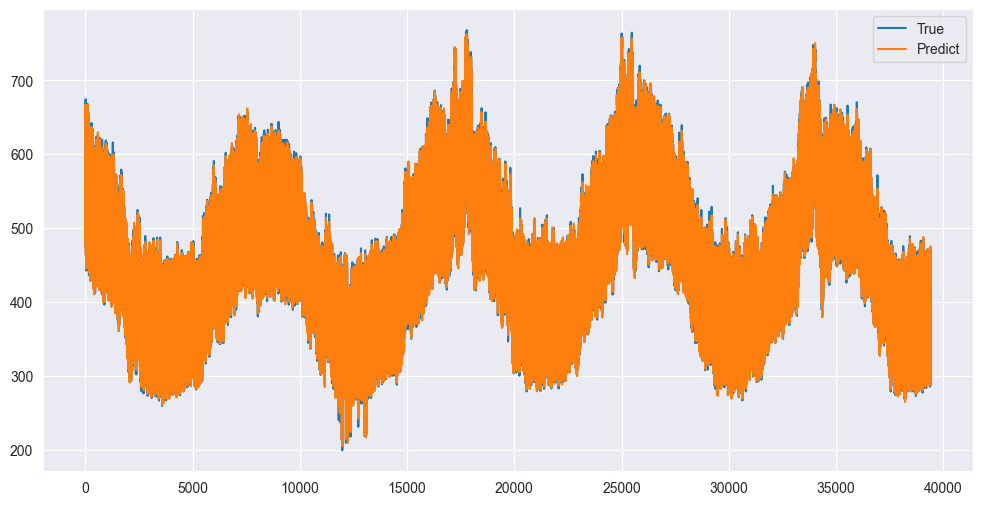

In [324]:
plt.figure(figsize=(12, 6))
plt.plot(np.array(target_full), label="True")
plt.plot(stack_pipeline.predict(features_full), label='Predict') #target_full.index, 
#plt.xlim(35000, 36000)
#plt.ylim(400, 700)
plt.legend();